In [1]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.io import loadmat
from scipy.io import savemat
import matplotlib.pyplot as plt 

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigs
from sklearn.cluster import KMeans
import copy

import csv
file = open('iris.txt', "rt", encoding="utf8")
pred_data = csv.reader(file, delimiter=',')
table = [row for row in pred_data]

# imports all the labels
y = np.empty((150,1))

for i in range(len(table) - 1):
    y_i = table[i+1][4]
    if y_i == "setosa" :
        y[i] = 0
    elif y_i == "versicolor":
        y[i] = 1
    elif y_i == "virginica":
        y[i] = 2
        
from sklearn.datasets.samples_generator import make_blobs

# imports all the corresponding features
data = np.genfromtxt('iris.csv', delimiter=',')
data = np.delete(data, (0), axis = 0)

A = np.delete(data, (4), axis = 1)
A = np.hstack((A,y))

A_init = np.delete(A, (4), axis = 1)

/Users/yash/Workspaces/Classes/ece532/Adversarial Machine Learning - KMeans/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


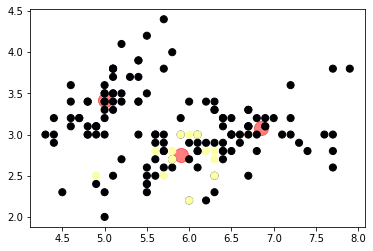

number of incorrect classification: 16


In [2]:
# trains a kmeans object from the sklearn library and returns it
def getKmeans(A,y):
    maxSquaredDistance = 10000
    for i in range(20):
        kmeans_t = KMeans(n_clusters=3)
        kmeans_t.fit(A)
        y_kmeans_t = kmeans_t.predict(A)
        y_kmeans_shape_t = np.reshape(y_kmeans_t,(len(y_kmeans_t),1))

        if(np.linalg.norm(y_kmeans_shape_t - y) < maxSquaredDistance):
            maxSquaredDistance = np.linalg.norm(y_kmeans_shape_t - y)
            kmeans = kmeans_t
            y_kmeans = y_kmeans_t
            y_kmeans_shape =  y_kmeans_shape_t
    return kmeans

# displays results of k-means
def displayKmeans(A,y,kmeans):
    y_eval = kmeans.predict(A)
    #plt.scatter(A[:, 0], A[:, 1], c=y_eval, s= 50, cmap='viridis')
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
    y_eval = np.reshape(y_eval,(150,1))
    err = [0 if i[0]==i[1] else 1 for i in np.hstack((y, y_eval))]
    plt.scatter(A[:, 0], A[:, 1], c=err, cmap='inferno',s=50);
    plt.show()
    print("number of incorrect classification: " + str(sum(err)))
    return sum(err)


kmeans = getKmeans(A_init,y)
original_errors = displayKmeans(A_init,y,kmeans)
y_original = kmeans.predict(A_init)
y_original = np.reshape(y_original,(150,1))

point which was moved was at index: 13
number of incorrect classification: 17


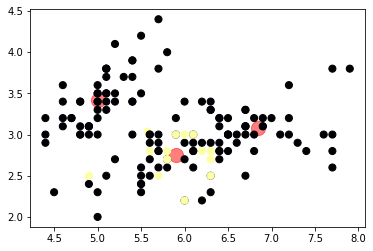

In [3]:
# now we will try to generate an input to give the pre-trained kmeans object we got earlier without re-training it
# and then show that if we changed added a certain number of incorrect classifications the the total number of
# incorrect classifications increase by more than the values we changed.

# returns 3 arrays which contain input data divided into clusters
def getClusters(X,y):
    l1 = []
    l2 = []
    l3 = []
    for i in range(len(y)):
        if(y[i] == 0):
            l1.append(X[i])
            
        if(y[i] == 1):
            l2.append(X[i])
            
        if(y[i] == 2):
            l3.append(X[i])
            
    return l1,l2,l3

# moves a selected point towards a centroid till it is classified incorrectly
def movePoint(x1,c,kmeans):
    prediction = True
    x_bad = (x1 + c)/2
    x_bad = np.reshape(x_bad,(1,4))
    x = np.reshape(x1,(1,4))
    while prediction:
        if(kmeans.predict(x_bad) == kmeans.predict(x)):
            x_bad = (x_bad + c)/2
        else:
            prediction = False
    return x_bad

def getPointAtMin(Xk,c):
    x_return = Xk[0]
    d_min = np.linalg.norm(x_return - c)
    for x in Xk:
        d = np.linalg.norm(x - c)
        if d_min < np.linalg.norm(x - c):
            d_min = d
            x_return = x
    return x_return

def generateBadData(A,y,kmeans):
    X = copy.deepcopy(A)
    c = kmeans.cluster_centers_[2]
    Xk0,Xk1,Xk2 = getClusters(X,y)
    Xk = Xk0
    x_orig = getPointAtMin(Xk,c) 
    
    # moves point towards different centroid
    x_bad = movePoint(x_orig,c,kmeans)
    index = 0
    # replaces new point inside X_bad
    X_bad = copy.deepcopy(X)        
    for i in range(150):
        if(all(X_bad[i] == x_orig)):
            X_bad[i] = x_bad
            index = i
    return X_bad,index

A_bad,index = generateBadData(A_init,y,kmeans)
print("point which was moved was at index: " + str(index))
new_error = displayKmeans(A_bad,y,kmeans)

# Now we have one more point which is incorrectly classified, but that's the one we moved
# so we'll try moving more points and see what happens



points which were moved: [13, 22, 42, 38, 41, 8, 2, 35, 47, 6, 12, 3, 40, 45, 1, 14, 4, 49, 37]
number of incorrect classification: 37
therfore number of additional incorrect classifications which we did not fabricate are: 2


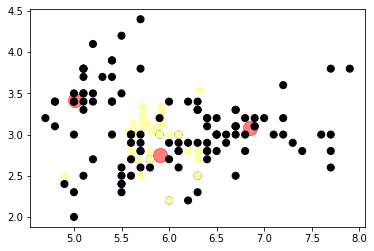

In [4]:
indices = []
indices.append(index)
n = 18
for i in range(n):
    y_new = kmeans.predict(A_bad)
    y_new = np.reshape(y_new,(150,1))
    A_bad,index = generateBadData(A_bad,y_new,kmeans)
    indices.append(index)
print("points which were moved: " + str(indices))
# this time we moved n more points and therefore the number of incorrect classifications should increase by n again
# but
error_final = displayKmeans(A_bad,y,kmeans)
print("therfore number of additional incorrect classifications which we did not fabricate are: " + str(error_final-new_error-n))


## play around with the value of n to see if the additional classifications change.


point incorrectly classified: 9
point incorrectly classified: 34


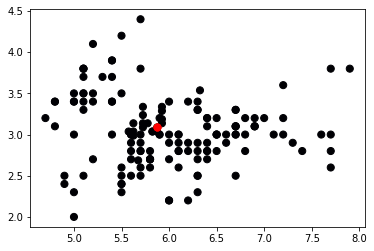

In [5]:
## showing exactly which points were incorrectly classified

y_eval = kmeans.predict(A_bad)
y_eval = np.reshape(y_eval,(150,1))
err = [0 if i[0]==i[1] else 1 for i in np.hstack((y_original, y_eval))]

for j in indices:
    err[j] = 0
for i in range(len(err)):
    if err[i] == 1:
        print("point incorrectly classified: " + str(i))
plt.scatter(A_bad[:, 0], A_bad[:, 1], c=err, cmap='inferno',s=50);
plt.scatter(A_bad[9, 0], A_bad[9, 1], c="red",s=50); ## hard-coded for n = 18
plt.scatter(A_bad[34, 0], A_bad[34, 1], c="red",s=50);

# points are really close
